### 📦 Library Imports
This block imports all necessary libraries including PyTorch, torchvision, matplotlib, and sklearn, which are used throughout the notebook for model creation, training, evaluation, and visualization.

In [1]:
import os  
import cv2  
import torch  
import random  
import numpy as np 
import matplotlib.pyplot as plt  
from tqdm import tqdm
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
import torchvision.transforms as transforms
import torch
import numpy as np
from PIL import Image

class AdditiveGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    AdditiveGaussianNoise(std=0.05),          
    transforms.GaussianBlur(kernel_size=5),   
    transforms.Normalize(mean=[0.5], std=[0.5])
])


### 🧠 Model Definition
This block initializes CNN architectures like ResNet-18 or VGG-16, potentially with pretrained weights, and modifies the classifier layers to adapt to the 15-class classification task.

In [3]:
config = {  
    "model_name": "resnet", 
    "num_epochs": 15,
    "batch_size": 32,
    "learning_rate": 0.001,
    "test_size": 0.2,
    "sample_ratio": 1.0
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset_path = "Aerial_Landscapes/"

In [4]:
def initialize_model(model_name, num_classes, use_pretrained=True):
    input_size = 224
    if model_name == "resnet":
        model = models.resnet18(pretrained=use_pretrained)  
        model.fc = nn.Linear(model.fc.in_features, num_classes)  
    elif model_name == "vgg":
        model = models.vgg16(pretrained=use_pretrained)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    else:
        raise ValueError("please choose resnet or vgg")
    return model, input_size

### 🧹 Data Preprocessing
This block defines image transformation pipelines such as resizing, cropping, normalization, and data augmentation using `torchvision.transforms`, to enhance model generalization.

In [5]:
def get_transforms(input_size=224):
    train_transform = transforms.Compose([  
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((input_size, input_size)),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),  
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + 0.05 * torch.randn_like(x)),  
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([  
        transforms.ToPILImage(),
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return train_transform, test_transform

In [6]:
class CustomDataset(Dataset): 
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image)
        return image, label

### ⚠️ Miscellaneous
This block performs auxiliary or intermediate tasks related to model training and setup.

In [7]:
def load_and_split_dataset(root_dir, test_size=0.2, sample_ratio=1.0):
    classes = sorted(os.listdir(root_dir))
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    train_images, train_labels = [], []
    test_images, test_labels = [], []

    for cls_name in classes:
        cls_path = os.path.join(root_dir, cls_name)
        img_files = [os.path.join(cls_path, f) for f in os.listdir(cls_path) if f.endswith('.jpg')]
        random.seed(42)
        random.shuffle(img_files)
        n_samples = int(len(img_files) * sample_ratio)
        split = int(n_samples * (1 - test_size))
        imgs = img_files[:n_samples]
        train_imgs = imgs[:split]
        test_imgs = imgs[split:]
        train_images.extend([cv2.imread(p) for p in train_imgs])
        train_labels.extend([class_to_idx[cls_name]] * len(train_imgs))
        test_images.extend([cv2.imread(p) for p in test_imgs])
        test_labels.extend([class_to_idx[cls_name]] * len(test_imgs))

    return (train_images, train_labels), (test_images, test_labels), classes

In [8]:
from tqdm import tqdm

def train_model(model, device, train_loader, test_loader, criterion, optimizer, 
                num_epochs=25, checkpoint_path='checkpoint.pth', patience=5):

    best_acc = 0.0
    epochs_no_improve = 0
    early_stop = False
    history = {
        'train_loss': [], 'train_acc': [],
        'test_loss': [], 'test_acc': []
    }

    for epoch in range(num_epochs):
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        for batch in train_loader_tqdm:
            if early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        model.train()
        train_loss, correct_train, total_train = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels.data)
            total_train += labels.size(0)

        epoch_train_loss = train_loss / total_train
        epoch_train_acc = correct_train.double() / total_train
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc.item())

        model.eval()
        test_loss, correct_test, total_test = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == labels.data)
                total_test += labels.size(0)

        epoch_test_loss = test_loss / total_test
        epoch_test_acc = correct_test.double() / total_test
        history['test_loss'].append(epoch_test_loss)
        history['test_acc'].append(epoch_test_acc.item())

        print(f"Epoch {epoch+1}: Train Acc={epoch_train_acc:.4f}, Test Acc={epoch_test_acc:.4f}")

        if epoch_test_acc > best_acc:
            best_acc = epoch_test_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), checkpoint_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                early_stop = True

    return model, history

### 📊 Evaluation
This part evaluates the trained model using test data and calculates metrics like accuracy, precision, recall, and F1-score.

In [9]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels)
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation='vertical', cmap='Blues')

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/15: 100%|██████████| 300/300 [00:18<00:00, 16.45batch/s]


Epoch 1: Train Acc=0.6624, Test Acc=0.7908


Epoch 2/15: 100%|██████████| 300/300 [00:19<00:00, 15.41batch/s]


Epoch 2: Train Acc=0.7678, Test Acc=0.7925


Epoch 3/15: 100%|██████████| 300/300 [00:18<00:00, 16.35batch/s]


Epoch 3: Train Acc=0.7983, Test Acc=0.8492


Epoch 4/15: 100%|██████████| 300/300 [00:24<00:00, 12.10batch/s]


Epoch 4: Train Acc=0.8222, Test Acc=0.8729


Epoch 5/15: 100%|██████████| 300/300 [00:29<00:00, 10.24batch/s]


Epoch 5: Train Acc=0.8348, Test Acc=0.8829


Epoch 6/15: 100%|██████████| 300/300 [00:28<00:00, 10.61batch/s]


Epoch 6: Train Acc=0.8433, Test Acc=0.8688


Epoch 7/15: 100%|██████████| 300/300 [00:27<00:00, 11.09batch/s]


Epoch 7: Train Acc=0.8515, Test Acc=0.8158


Epoch 8/15: 100%|██████████| 300/300 [00:27<00:00, 10.82batch/s]


Epoch 8: Train Acc=0.8629, Test Acc=0.9121


Epoch 9/15: 100%|██████████| 300/300 [00:27<00:00, 10.80batch/s]


Epoch 9: Train Acc=0.8666, Test Acc=0.9096


Epoch 10/15: 100%|██████████| 300/300 [00:27<00:00, 11.00batch/s]


Epoch 10: Train Acc=0.8727, Test Acc=0.9092


Epoch 11/15: 100%|██████████| 300/300 [00:26<00:00, 11.27batch/s]


Epoch 11: Train Acc=0.8760, Test Acc=0.9200


Epoch 12/15: 100%|██████████| 300/300 [00:28<00:00, 10.54batch/s]


Epoch 12: Train Acc=0.8804, Test Acc=0.9283


Epoch 13/15: 100%|██████████| 300/300 [00:29<00:00, 10.26batch/s]


Epoch 13: Train Acc=0.8814, Test Acc=0.9196


Epoch 14/15: 100%|██████████| 300/300 [00:28<00:00, 10.37batch/s]


Epoch 14: Train Acc=0.8876, Test Acc=0.9200


Epoch 15/15: 100%|██████████| 300/300 [00:32<00:00,  9.29batch/s]


Epoch 15: Train Acc=0.8883, Test Acc=0.9271
Evaluation Metrics (Precision, Recall, F1-score):

              precision    recall  f1-score   support

 Agriculture     0.8895    0.9563    0.9217       160
     Airport     0.8590    0.8375    0.8481       160
       Beach     0.8824    0.9375    0.9091       160
        City     0.9198    0.9313    0.9255       160
      Desert     0.9128    0.9812    0.9458       160
      Forest     0.9506    0.9625    0.9565       160
   Grassland     0.9739    0.9313    0.9521       160
     Highway     0.8882    0.9437    0.9152       160
        Lake     0.9162    0.9563    0.9358       160
    Mountain     0.9490    0.9313    0.9401       160
     Parking     0.9934    0.9437    0.9679       160
        Port     0.9341    0.9750    0.9541       160
     Railway     0.9404    0.8875    0.9132       160
 Residential     0.9932    0.9062    0.9477       160
       River     0.9231    0.8250    0.8713       160

    accuracy                         0.

<Figure size 1200x1000 with 0 Axes>

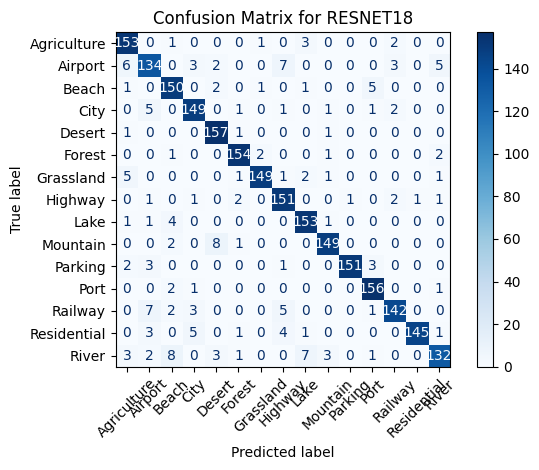

In [10]:
(train_images, train_labels), (test_images, test_labels), classes = load_and_split_dataset(
    dataset_path,
    test_size=config["test_size"], 
    sample_ratio=config["sample_ratio"]  
)

model, input_size = initialize_model(
    model_name=config["model_name"], 
    num_classes=len(classes),
    use_pretrained=True
)
model = model.to(device)

train_transform, test_transform = get_transforms(input_size)

train_dataset = CustomDataset(train_images, train_labels, train_transform)
test_dataset = CustomDataset(test_images, test_labels, test_transform)
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)  
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])  

model, history = train_model(
    model, device, train_loader, test_loader,
    criterion, optimizer,
    num_epochs=config["num_epochs"], 
    patience=5
)

model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels)
        y_pred.extend(preds.cpu().numpy())

report = classification_report(y_true, y_pred, target_names=classes, digits=4)
print("Evaluation Metrics (Precision, Recall, F1-score):\n")
print(report)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
plt.figure(figsize=(12, 10))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix for RESNET18")
plt.grid(False)
plt.tight_layout()
plt.show()

In [11]:
def train_vgg_model(model, device, train_loader, val_loader, criterion, optimizer, num_epochs=10):  
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"): 
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        train_losses.append(running_loss / len(train_loader))
        train_accs.append(correct / total)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(val_correct / val_total)

        print(f"[VGG] Epoch {epoch+1}/{num_epochs} - Train Acc: {train_accs[-1]:.4f} - Val Acc: {val_accs[-1]:.4f}")

    import matplotlib.pyplot as plt 
    import numpy as np 
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss", c="red")
    plt.plot(val_losses, label="Val Loss", c="blue")
    plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend(); plt.show()
    plt.figure(figsize=(10, 5))
    plt.plot(train_accs, label="Train Acc", c="orangered")
    plt.plot(val_accs, label="Val Acc", c="green")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/15:   1%|▏         | 4/300 [00:01<01:13,  4.01it/s]

Epoch 1/15: 100%|██████████| 300/300 [01:04<00:00,  4.67it/s]


[VGG] Epoch 1/15 - Train Acc: 0.1500 - Val Acc: 0.1733


Epoch 2/15: 100%|██████████| 300/300 [00:56<00:00,  5.29it/s]


[VGG] Epoch 2/15 - Train Acc: 0.2469 - Val Acc: 0.2883


Epoch 3/15: 100%|██████████| 300/300 [00:56<00:00,  5.33it/s]


[VGG] Epoch 3/15 - Train Acc: 0.2885 - Val Acc: 0.3275


Epoch 4/15: 100%|██████████| 300/300 [00:56<00:00,  5.28it/s]


[VGG] Epoch 4/15 - Train Acc: 0.3317 - Val Acc: 0.3596


Epoch 5/15: 100%|██████████| 300/300 [00:56<00:00,  5.33it/s]


[VGG] Epoch 5/15 - Train Acc: 0.3618 - Val Acc: 0.3646


Epoch 6/15: 100%|██████████| 300/300 [00:56<00:00,  5.30it/s]


[VGG] Epoch 6/15 - Train Acc: 0.4035 - Val Acc: 0.4725


Epoch 7/15: 100%|██████████| 300/300 [00:56<00:00,  5.33it/s]


[VGG] Epoch 7/15 - Train Acc: 0.4533 - Val Acc: 0.5067


Epoch 8/15: 100%|██████████| 300/300 [00:56<00:00,  5.32it/s]


[VGG] Epoch 8/15 - Train Acc: 0.4830 - Val Acc: 0.5337


Epoch 9/15: 100%|██████████| 300/300 [00:56<00:00,  5.28it/s]


[VGG] Epoch 9/15 - Train Acc: 0.5022 - Val Acc: 0.5375


Epoch 10/15: 100%|██████████| 300/300 [00:56<00:00,  5.32it/s]


[VGG] Epoch 10/15 - Train Acc: 0.4836 - Val Acc: 0.5333


Epoch 11/15: 100%|██████████| 300/300 [00:56<00:00,  5.33it/s]


[VGG] Epoch 11/15 - Train Acc: 0.5252 - Val Acc: 0.5363


Epoch 12/15: 100%|██████████| 300/300 [00:56<00:00,  5.29it/s]


[VGG] Epoch 12/15 - Train Acc: 0.5444 - Val Acc: 0.5746


Epoch 13/15: 100%|██████████| 300/300 [00:56<00:00,  5.33it/s]


[VGG] Epoch 13/15 - Train Acc: 0.5618 - Val Acc: 0.6029


Epoch 14/15: 100%|██████████| 300/300 [00:56<00:00,  5.28it/s]


[VGG] Epoch 14/15 - Train Acc: 0.5740 - Val Acc: 0.6350


Epoch 15/15: 100%|██████████| 300/300 [00:56<00:00,  5.31it/s]


[VGG] Epoch 15/15 - Train Acc: 0.5751 - Val Acc: 0.6104


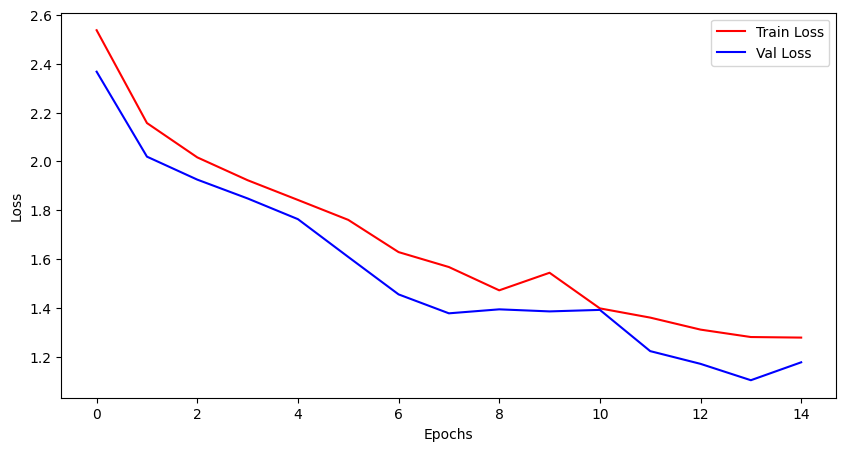

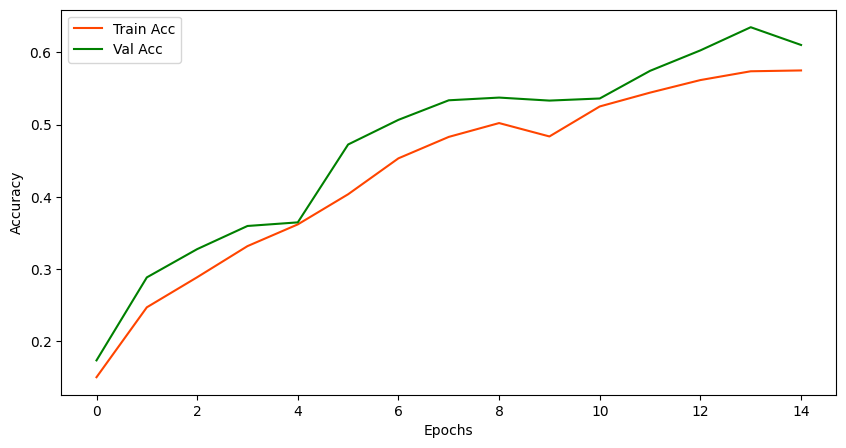

In [12]:
vgg_model = initialize_model("vgg", num_classes=len(classes))[0].to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg_model.parameters(), lr=config["learning_rate"]) 

train_vgg_model(vgg_model, device, train_loader, test_loader, criterion, optimizer, num_epochs=config["num_epochs"]) 

-------- VGG Evaluation Metrics --------


              precision    recall  f1-score   support

 Agriculture       0.44      0.81      0.57       160
     Airport       0.48      0.24      0.32       160
       Beach       0.82      0.65      0.72       160
        City       0.61      0.58      0.60       160
      Desert       0.93      0.85      0.89       160
      Forest       0.84      0.84      0.84       160
   Grassland       0.87      0.74      0.80       160
     Highway       0.35      0.28      0.31       160
        Lake       0.73      0.71      0.72       160
    Mountain       0.52      0.59      0.55       160
     Parking       0.79      0.84      0.81       160
        Port       0.99      0.46      0.63       160
     Railway       0.42      0.50      0.46       160
 Residential       0.46      0.82      0.59       160
       River       0.33      0.24      0.28       160

    accuracy                           0.61      2400
   macro avg       0.64      0.61      0.61      2400
weighted avg       0.64   

Text(0.5, 1.0, 'Confusion Matrix for VGG16')

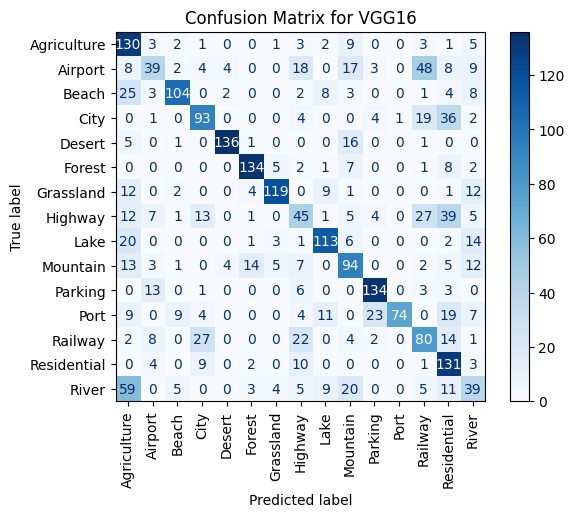

In [13]:
print("-------- VGG Evaluation Metrics --------")
evaluate_model(vgg_model, test_loader, device, class_names=classes)
plt.title(f"Confusion Matrix for VGG16")

In [14]:
import os  
import cv2  
import torch 
import numpy as np 
import matplotlib.pyplot as plt  
from collections import defaultdict
from torchcam.methods import GradCAM

def overlay_heatmap(img: np.ndarray, cam: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    cam_uint8 = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(cam_uint8, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    if img.max() > 1.0:
        img = np.float32(img) / 255
    if img.shape[:2] != heatmap.shape[:2]:
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    overlayed = heatmap * alpha + img
    overlayed = overlayed / np.max(overlayed)
    return np.uint8(255 * overlayed)

def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def apply_gradcam_all_classes(model, device, dataloader, model_name="resnet", save_dir="gradcam_outputs"):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    if model_name == "resnet":
        target_layer = model.layer4[-1].conv2
    elif model_name == "vgg":
        target_layer = model.features[-1]
    else:
        raise ValueError("Unsupported model")

    cam_extractor = GradCAM(model, target_layer=target_layer)

    seen_classes = defaultdict(int)
    total_target_classes = 15
    class_id_to_name = [
        "Agriculture", "Airport", "Beach", "City", "Desert", "Forest", "Grassland", "Highway",
        "Lake", "Mountain", "Parking", "Port", "Railway", "Residential", "River"
    ]

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        for i in range(inputs.shape[0]):
            label = labels[i].item()
            if seen_classes[label] >= 1:
                continue 

            img_tensor = inputs[i].unsqueeze(0)
            output = model(img_tensor)
            class_idx = torch.argmax(output).item()

            cam_tensor = cam_extractor(class_idx=class_idx, scores=output)[0]
            cam = cam_tensor.cpu().numpy()
            if cam.ndim == 3:
                cam = cam[0]
            cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

            unnorm_img_tensor = unnormalize(img_tensor.squeeze(0).cpu(),
                                            mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])
            raw_image = np.clip(unnorm_img_tensor.permute(1, 2, 0).numpy(), 0, 1)

            cam = cv2.resize(cam, (raw_image.shape[1], raw_image.shape[0]))
            result = overlay_heatmap(raw_image, cam)
            result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

            orig_img = np.uint8(raw_image * 255)
            orig_bgr = cv2.cvtColor(orig_img, cv2.COLOR_RGB2BGR)
            result_bgr = cv2.cvtColor(result_rgb, cv2.COLOR_RGB2BGR)

            cname = class_id_to_name[label]
            cv2.imwrite(os.path.join(save_dir, f"{cname}_original.png"), orig_bgr)
            cv2.imwrite(os.path.join(save_dir, f"{cname}_gradcam.png"), result_bgr)
            cv2.imwrite(os.path.join(save_dir, f"{cname}_compare.png"), np.hstack((orig_bgr, result_bgr)))

            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            axs[0].imshow(orig_img)
            axs[0].set_title(f"{cname} - Original")
            axs[0].axis('off')
            axs[1].imshow(result_rgb)
            axs[1].set_title(f"{cname} - GradCAM (Pred: {class_id_to_name[class_idx]})")
            axs[1].axis('off')
            plt.tight_layout()
            plt.show()

            seen_classes[label] += 1

        if len(seen_classes) >= total_target_classes:
            print("Grad-CAM DONE!")
            break

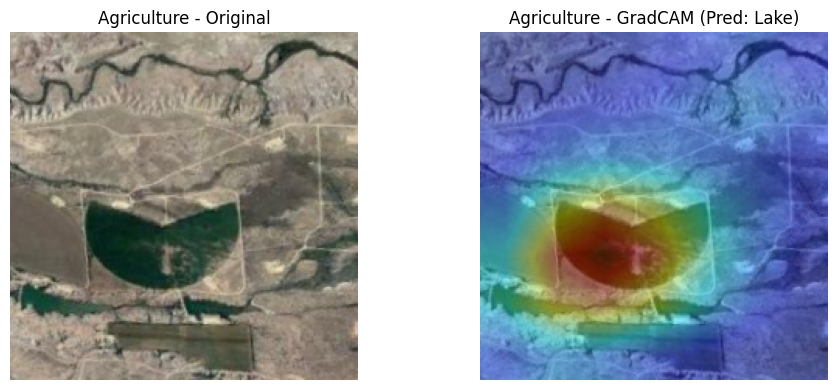

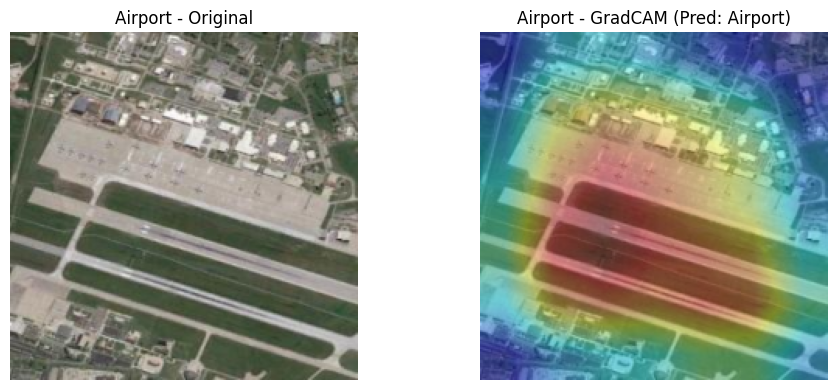

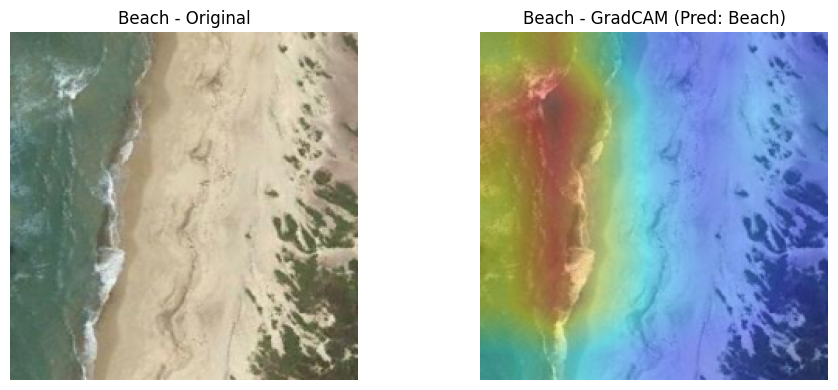

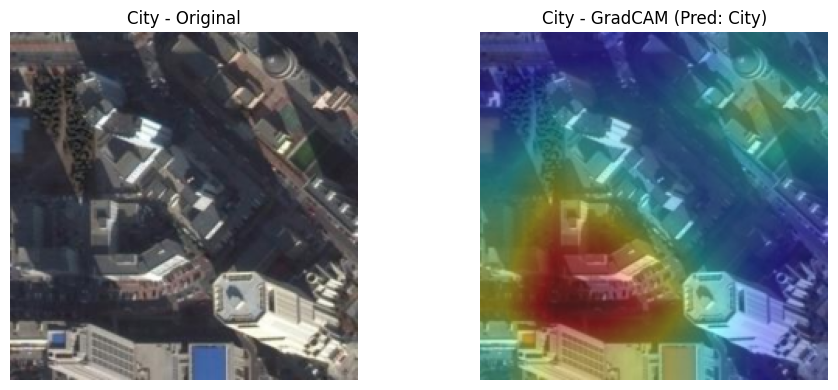

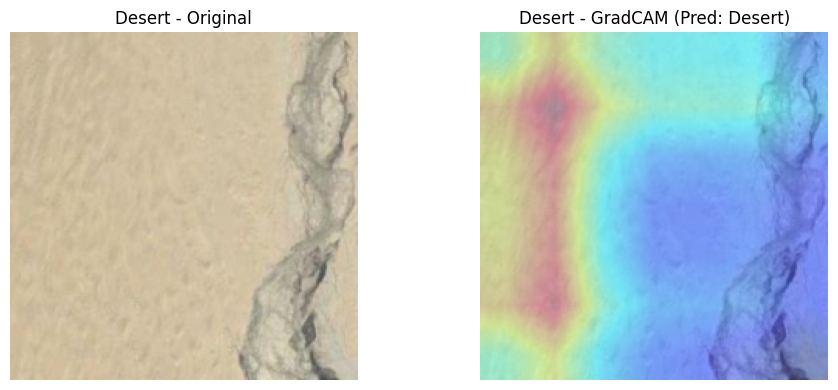

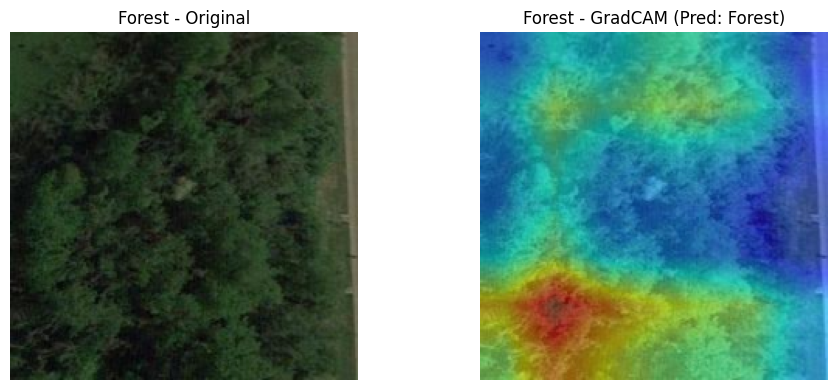

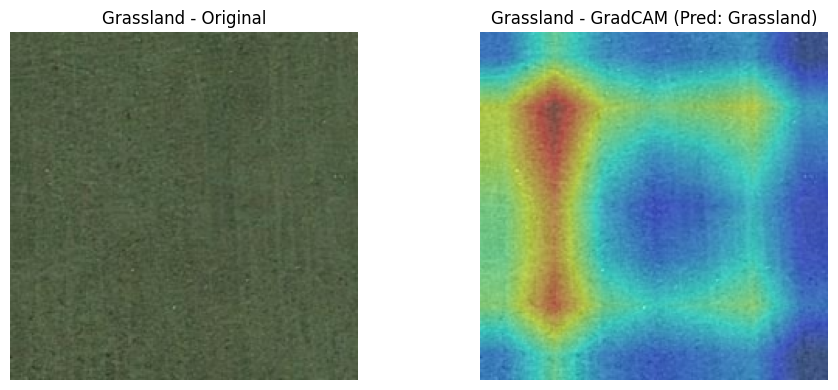

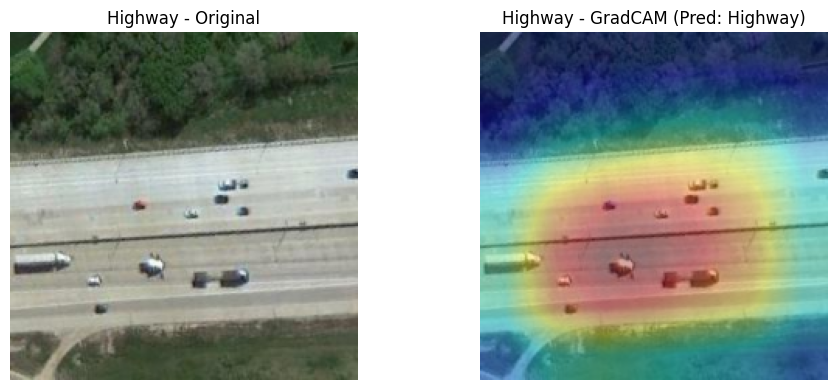

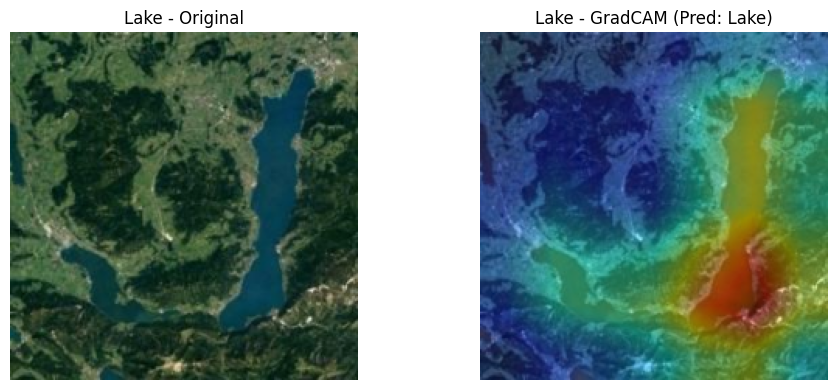

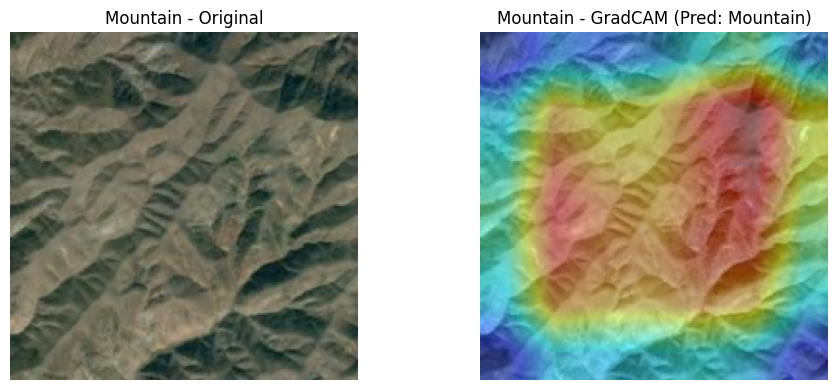

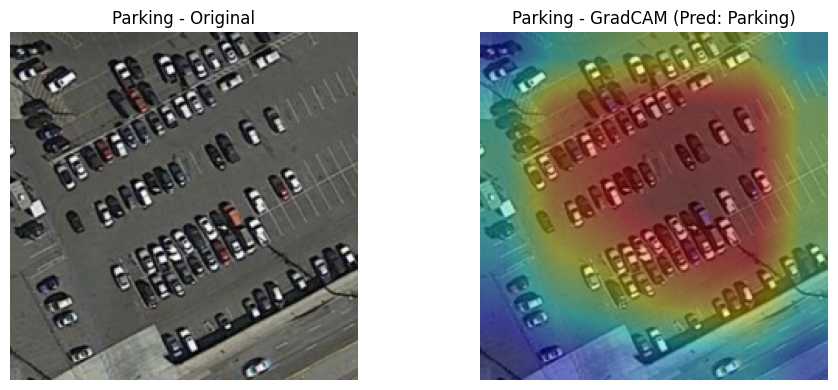

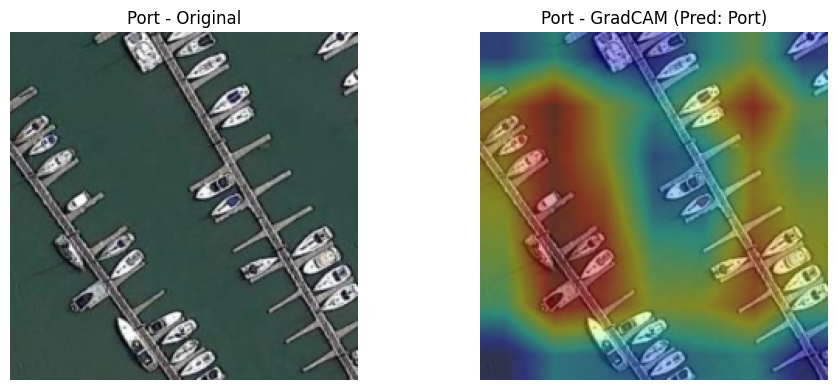

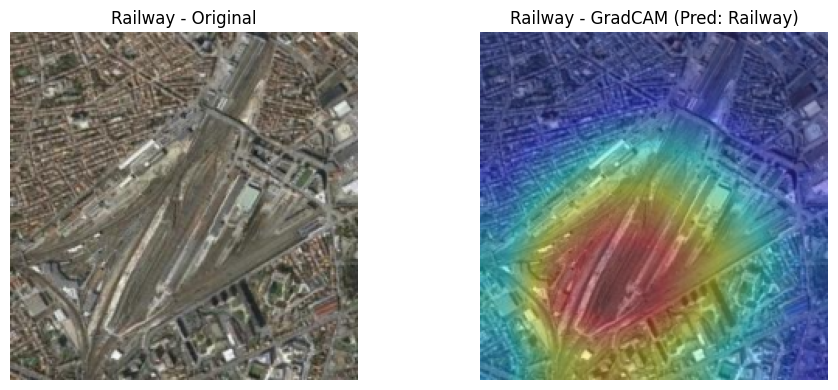

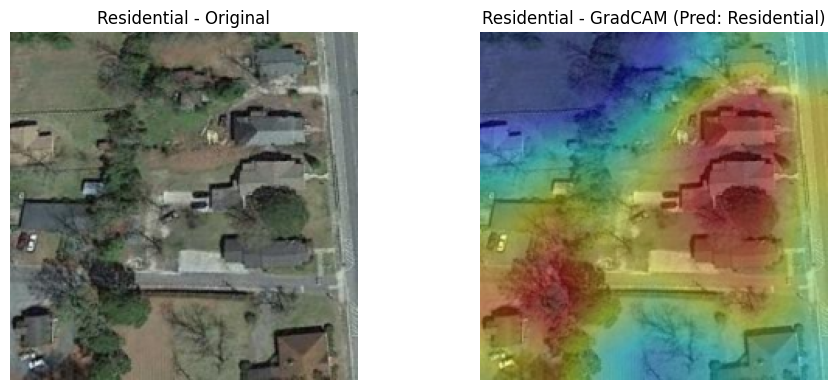

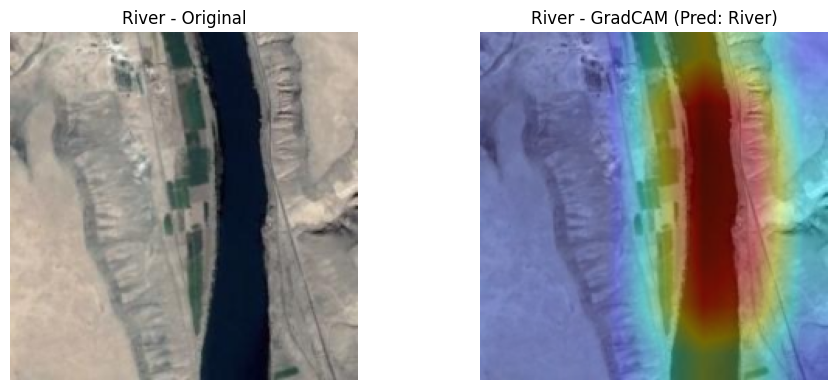

Grad-CAM DONE!


In [15]:
apply_gradcam_all_classes(model, device, test_loader, model_name="resnet")

In [16]:
from PIL import ImageDraw

class RandomOcclusion:
    def __init__(self, size=(60, 60)):
        self.size = size

    def __call__(self, img):
        w, h = img.size
        x0 = w // 2 - self.size[0] // 2
        y0 = h // 2 - self.size[1] // 2
        x1 = x0 + self.size[0]
        y1 = y0 + self.size[1]
        draw = ImageDraw.Draw(img)
        draw.rectangle([x0, y0, x1, y1], fill=(0, 0, 0))
        return img


In [17]:
from torchvision import transforms

occluded_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    RandomOcclusion(size=(60, 60)),  # make sure RandomOcclusion class is defined earlier
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])


/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


-------- ResNet under Occlusion --------


              precision    recall  f1-score   support

 Agriculture       0.00      0.00      0.00       160
     Airport       0.00      0.00      0.00       160
       Beach       0.00      0.00      0.00       160
        City       0.09      0.03      0.04       160
      Desert       0.03      0.01      0.02       160
      Forest       0.01      0.01      0.01       160
   Grassland       0.00      0.00      0.00       160
     Highway       0.50      0.03      0.05       160
        Lake       0.04      0.05      0.05       160
    Mountain       0.19      0.08      0.11       160
     Parking       0.05      0.04      0.05       160
        Port       0.00      0.00      0.00       160
     Railway       0.04      0.37      0.08       160
 Residential       0.03      0.01      0.02       160
       River       0.03      0.03      0.03       160

    accuracy                           0.04      2400
   macro avg       0.07      0.04      0.03      2400
weighted avg       0.07   

/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

 Agriculture       0.33      0.53      0.41       160
     Airport       0.62      0.06      0.11       160
       Beach       0.84      0.56      0.67       160
        City       0.47      0.68      0.56       160
      Desert       0.96      0.80      0.87       160
      Forest       0.00      0.00      0.00       160
   Grassland       0.95      0.46      0.62       160
     Highway       0.12      0.06      0.08       160
        Lake       0.16      0.84      0.27       160
    Mountain       0.00      0.00      0.00       160
     Parking       0.84      0.80      0.82       160
        Port       0.92      0.49      0.64       160
     Railway       0.33      0.01      0.01       160
 Residential       0.42      0.71      0.52       160
       River       0.11      0.11      0.11       160

    accuracy                           0.41      2400
   macro avg       0.47      0.41      0.38      2400
weighted avg       0.47   

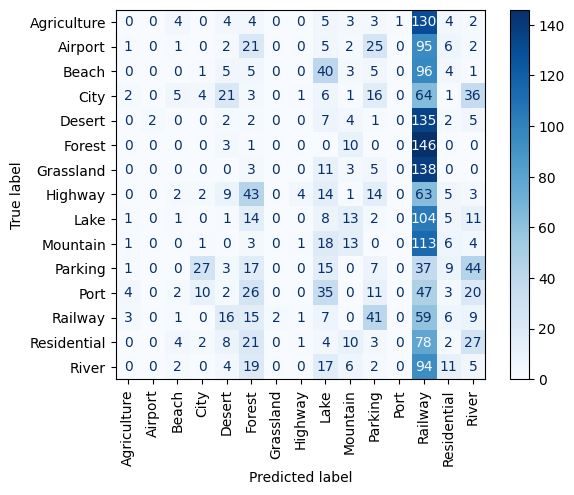

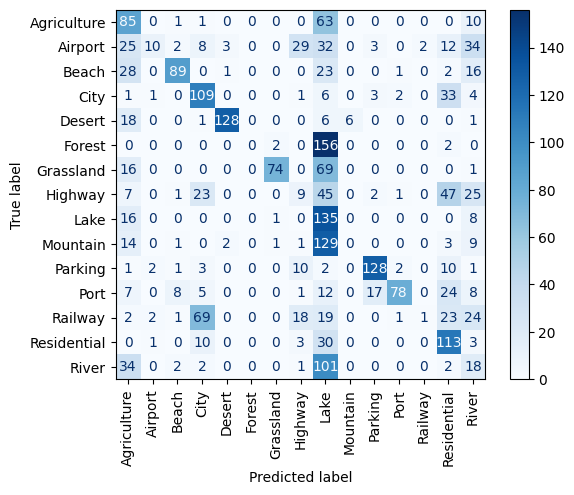

In [18]:
resnet_model = initialize_model("resnet", num_classes=len(classes))[0].to(device)
resnet_model.eval()

occluded_dataset = CustomDataset(test_images, test_labels, transform=occluded_test_transform)
occluded_loader = DataLoader(occluded_dataset, batch_size=32, shuffle=False)

print("-------- ResNet under Occlusion --------")
evaluate_model(resnet_model, occluded_loader, device, class_names=classes)

print("-------- VGG under Occlusion --------")
evaluate_model(vgg_model, occluded_loader, device, class_names=classes)


In [19]:
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'


In [20]:
from PIL import ImageFilter

class ApplyGaussianBlur(object):
    def __init__(self, radius=2):
        self.radius = radius

    def __call__(self, img):
        return img.filter(ImageFilter.GaussianBlur(self.radius))

    def __repr__(self):
        return self.__class__.__name__ + f'(radius={self.radius})'


In [21]:
gaussian_noise_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    AddGaussianNoise(mean=0.0, std=0.1),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [22]:
gaussian_blur_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    ApplyGaussianBlur(radius=2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [23]:
gaussian_noise_dataset = CustomDataset(test_images, test_labels, transform=gaussian_noise_transform)
gaussian_noise_loader = DataLoader(gaussian_noise_dataset, batch_size=32, shuffle=False)

gaussian_blur_dataset = CustomDataset(test_images, test_labels, transform=gaussian_blur_transform)
gaussian_blur_loader = DataLoader(gaussian_blur_dataset, batch_size=32, shuffle=False)


-------- ResNet under Gaussian Noise --------


/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

 Agriculture       0.00      0.00      0.00       160
     Airport       0.00      0.00      0.00       160
       Beach       0.00      0.00      0.00       160
        City       0.16      0.12      0.14       160
      Desert       0.04      0.01      0.02       160
      Forest       0.00      0.00      0.00       160
   Grassland       0.00      0.00      0.00       160
     Highway       0.00      0.00      0.00       160
        Lake       0.01      0.01      0.01       160
    Mountain       0.04      0.04      0.04       160
     Parking       0.15      0.27      0.20       160
        Port       0.00      0.00      0.00       160
     Railway       0.05      0.39      0.09       160
 Residential       0.02      0.04      0.03       160
       River       0.00      0.00      0.00       160

    accuracy                           0.06      2400
   macro avg       0.03      0.06      0.03      2400
weighted avg       0.03   

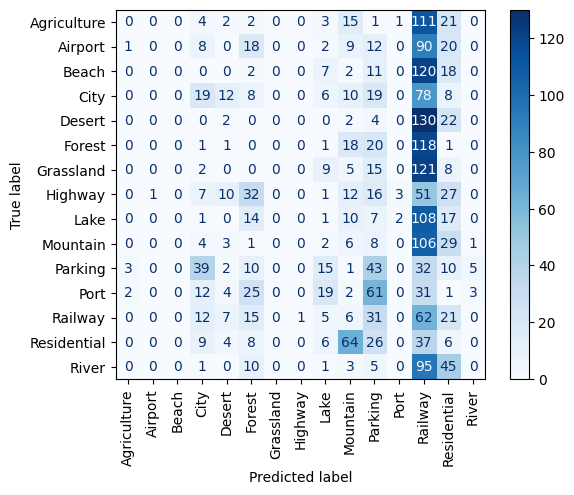

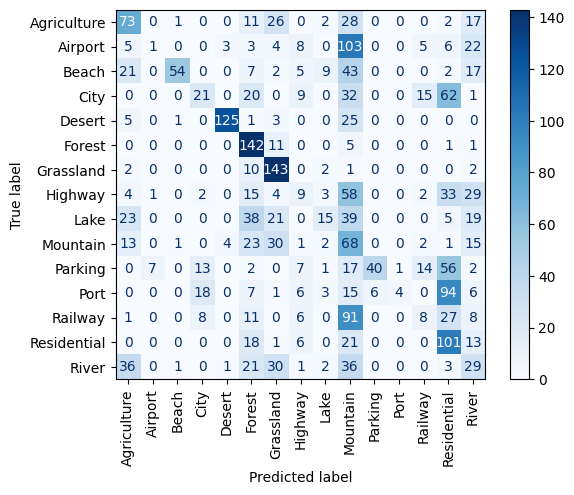

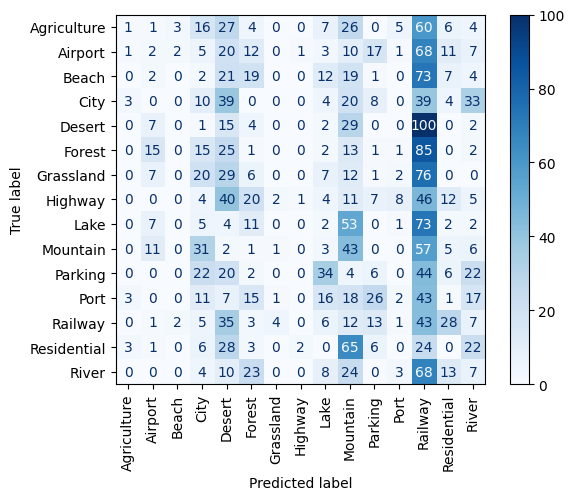

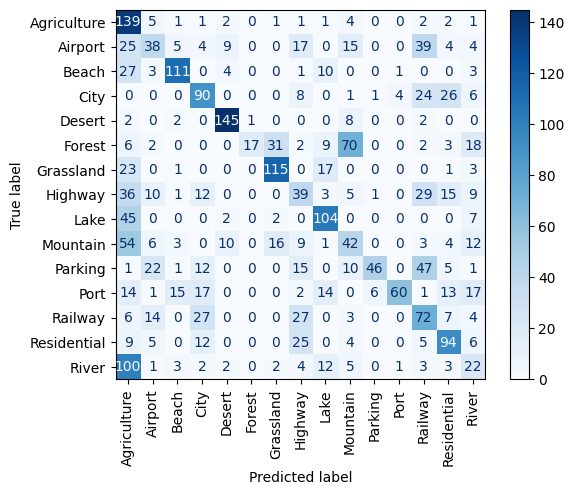

In [24]:
print("-------- ResNet under Gaussian Noise --------")
evaluate_model(resnet_model, gaussian_noise_loader, device, class_names=classes)

print("-------- VGG under Gaussian Noise --------")
evaluate_model(vgg_model, gaussian_noise_loader, device, class_names=classes)

print("-------- ResNet under Gaussian Blur --------")
evaluate_model(resnet_model, gaussian_blur_loader, device, class_names=classes)

print("-------- VGG under Gaussian Blur --------")
evaluate_model(vgg_model, gaussian_blur_loader, device, class_names=classes)
